<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 471, '日付': '2021-06-01T08:00:00.000Z'},
 {'小計': 487, '日付': '2021-06-02T08:00:00.000Z'},
 {'小計': 508, '日付': '2021-06-03T08:00:00.000Z'},
 {'小計': 472, '日付': '2021-06-04T08:00:00.000Z'},
 {'小計': 436, '日付': '2021-06-05T08:00:00.000Z'},
 {'小計': 351, '日付': '2021-06-06T08:00:00.000Z'},
 {'小計': 235, '日付': '2021-06-07T08:00:00.000Z'},
 {'小計': 369, '日付': '2021-06-08T08:00:00.000Z'},
 {'小計': 440, '日付': '2021-06-09T08:00:00.000Z'},
 {'小計': 439, '日付': '2021-06-10T08:00:00.000Z'},
 {'小計': 435, '日付': '2021-06-11T08:00:00.000Z'},
 {'小計': 467, '日付': '2021-06-12T08:00:00.000Z'},
 {'小計': 304, '日付': '2021-06-13T08:00:00.000Z'},
 {'小計': 209, '日付': '2021-06-14T08:00:00.000Z'},
 {'小計': 337, '日付': '2021-06-15T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-06-11 17:00:00+09:00,313,0,435,2021-06-11 17:00:00+09:00
2021-06-12 17:00:00+09:00,350,0,467,2021-06-12 17:00:00+09:00
2021-06-13 17:00:00+09:00,283,0,304,2021-06-13 17:00:00+09:00
2021-06-14 17:00:00+09:00,354,0,209,2021-06-14 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-06-11 17:00:00+09:00,313,0,435,2021-06-11 17:00:00+09:00,333.857143,2337.0,0.0,0.0,386.428571,2705.0
2021-06-12 17:00:00+09:00,350,0,467,2021-06-12 17:00:00+09:00,332.000000,2324.0,0.0,0.0,390.857143,2736.0
2021-06-13 17:00:00+09:00,283,0,304,2021-06-13 17:00:00+09:00,326.857143,2288.0,0.0,0.0,384.142857,2689.0
2021-06-14 17:00:00+09:00,354,0,209,2021-06-14 17:00:00+09:00,321.571429,2251.0,0.0,0.0,380.428571,2663.0
2021-06-15 17:00:00+09:00,0,0,337,2021-06-15 17:00:00+09:00,279.714286,1958.0,0.0,0.0,375.857143,2631.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-06-01 17:00:00+09:00,400,0,471,2021-06-01 17:00:00+09:00,409.285714,2865.0,0.0,0.0,537.000000,3759.0,'21w22,Tue
2021-06-02 17:00:00+09:00,388,0,487,2021-06-02 17:00:00+09:00,404.142857,2829.0,0.0,0.0,500.428571,3503.0,'21w22,Wed
2021-06-03 17:00:00+09:00,371,0,508,2021-06-03 17:00:00+09:00,396.285714,2774.0,0.0,0.0,475.285714,3327.0,'21w22,Thu
2021-06-04 17:00:00+09:00,340,0,472,2021-06-04 17:00:00+09:00,386.285714,2704.0,0.0,0.0,455.000000,3185.0,'21w22,Fri
2021-06-05 17:00:00+09:00,363,0,436,2021-06-05 17:00:00+09:00,378.285714,2648.0,0.0,0.0,440.285714,3082.0,'21w22,Sat
2021-06-06 17:00:00+09:00,319,0,351,2021-06-06 17:00:00+09:00,377.285714,2641.0,0.0,0.0,426.428571,2985.0,'21w22,Sun
2021-06-07 17:00:00+09:00,391,0,235,2021-06-07 17:00:00+09:00,367.428571,2572.0,0.0,0.0,422.857143,2960.0,'21w23,Mon
2021-06-08 17:00:00+09:00,293,0,369,2021-06-08 17:00:00+09:00,352.142857,2465.0,0.0,0.0,408.285714,2858.0,'21w23,Tue
2021-06-09 17:00:00+09:00,336,0,440,2021-06-09 17:00:00+09:00,344.714286,2413.0,0.0,0.0,401.571429,2811.0,'21w23,Wed
2021-06-10 17:00:00+09:00,322,0,439,2021-06-10 17:00:00+09:00,337.714286,2364.0,0.0,0.0,391.714286,2742.0,'21w23,Thu


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-05-30 17:00:00+09:00,558.571429,3910
2021-06-06 17:00:00+09:00,426.428571,2985
2021-06-13 17:00:00+09:00,384.142857,2689
2021-06-15 17:00:00+09:00,273.000000,546
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-06-01 17:00:00+09:00,400,0,471,2021-06-01 17:00:00+09:00,409.285714,2865.0,0.0,0.0,537.000000,3759.0,'21w22,Tue,NaN,NaN
2021-06-02 17:00:00+09:00,388,0,487,2021-06-02 17:00:00+09:00,404.142857,2829.0,0.0,0.0,500.428571,3503.0,'21w22,Wed,NaN,NaN
2021-06-03 17:00:00+09:00,371,0,508,2021-06-03 17:00:00+09:00,396.285714,2774.0,0.0,0.0,475.285714,3327.0,'21w22,Thu,NaN,NaN
2021-06-04 17:00:00+09:00,340,0,472,2021-06-04 17:00:00+09:00,386.285714,2704.0,0.0,0.0,455.000000,3185.0,'21w22,Fri,NaN,NaN
2021-06-05 17:00:00+09:00,363,0,436,2021-06-05 17:00:00+09:00,378.285714,2648.0,0.0,0.0,440.285714,3082.0,'21w22,Sat,NaN,NaN
2021-06-06 17:00:00+09:00,319,0,351,2021-06-06 17:00:00+09:00,377.285714,2641.0,0.0,0.0,426.428571,2985.0,'21w22,Sun,426.428571,2985.0
2021-06-07 17:00:00+09:00,391,0,235,2021-06-07 17:00:00+09:00,367.428571,2572.0,0.0,0.0,422.857143,2960.0,'21w23,Mon,NaN,NaN
2021-06-08 17:00:00+09:00,293,0,369,2021-06-08 17:00:00+09:00,352.142857,2465.0,0.0,0.0,408.285714,2858.0,'21w23,Tue,NaN,NaN
2021-06-09 17:00:00+09:00,336,0,440,2021-06-09 17:00:00+09:00,344.714286,2413.0,0.0,0.0,401.571429,2811.0,'21w23,Wed,NaN,NaN
2021-06-10 17:00:00+09:00,322,0,439,2021-06-10 17:00:00+09:00,337.714286,2364.0,0.0,0.0,391.714286,2742.0,'21w23,Thu,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

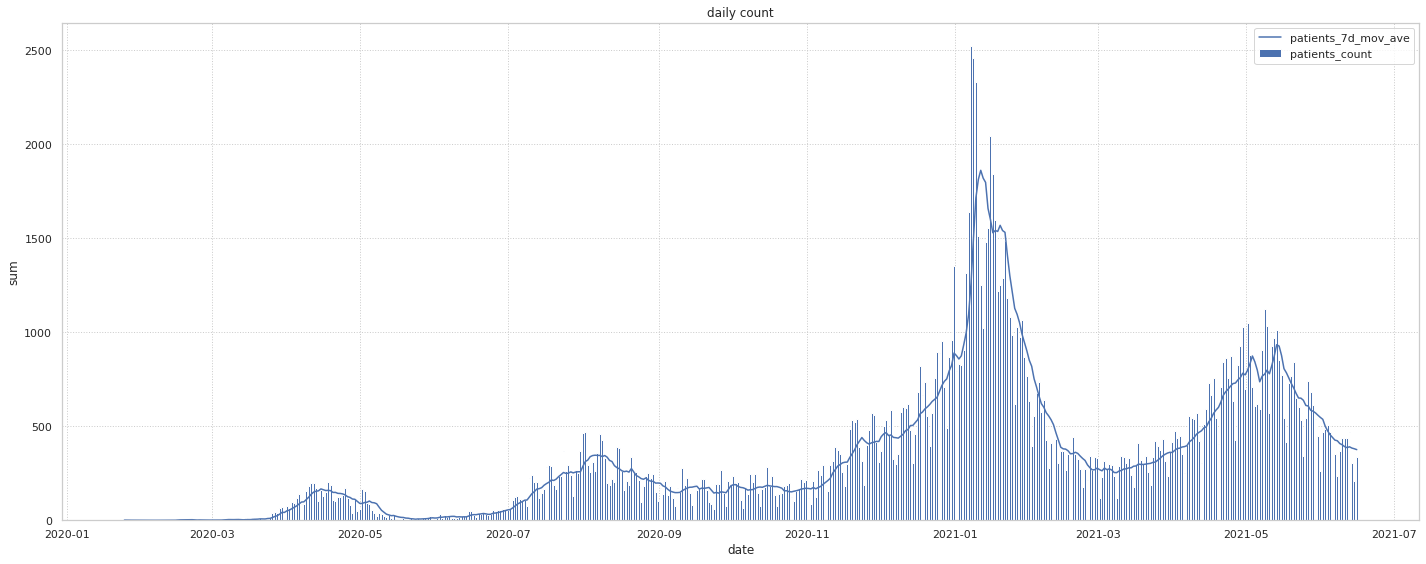

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
494,1.622534e+09,2021,6,1,0,0,0,0,0,1,0,494,0,420,400,409.285714,2865.0,0,0.0,0.0,471,537.000000,3759.0
495,1.622621e+09,2021,6,2,0,0,0,0,0,0,1,495,0,421,388,404.142857,2829.0,0,0.0,0.0,487,500.428571,3503.0
496,1.622707e+09,2021,6,3,0,0,0,0,1,0,0,496,0,422,371,396.285714,2774.0,0,0.0,0.0,508,475.285714,3327.0
497,1.622794e+09,2021,6,4,1,0,0,0,0,0,0,497,0,423,340,386.285714,2704.0,0,0.0,0.0,472,455.000000,3185.0
498,1.622880e+09,2021,6,5,0,0,1,0,0,0,0,498,0,424,363,378.285714,2648.0,0,0.0,0.0,436,440.285714,3082.0
499,1.622966e+09,2021,6,6,0,0,0,1,0,0,0,499,0,425,319,377.285714,2641.0,0,0.0,0.0,351,426.428571,2985.0
500,1.623053e+09,2021,6,7,0,1,0,0,0,0,0,500,0,426,391,367.428571,2572.0,0,0.0,0.0,235,422.857143,2960.0
501,1.623139e+09,2021,6,8,0,0,0,0,0,1,0,501,0,427,293,352.142857,2465.0,0,0.0,0.0,369,408.285714,2858.0
502,1.623226e+09,2021,6,9,0,0,0,0,0,0,1,502,0,428,336,344.714286,2413.0,0,0.0,0.0,440,401.571429,2811.0
503,1.623312e+09,2021,6,10,0,0,0,0,1,0,0,503,0,429,322,337.714286,2364.0,0,0.0,0.0,439,391.714286,2742.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            509 non-null    float64
 1   year                 509 non-null    int64  
 2   month                509 non-null    int64  
 3   day                  509 non-null    int64  
 4   Fri                  509 non-null    uint8  
 5   Mon                  509 non-null    uint8  
 6   Sat                  509 non-null    uint8  
 7   Sun                  509 non-null    uint8  
 8   Thu                  509 non-null    uint8  
 9   Tue                  509 non-null    uint8  
 10  Wed                  509 non-null    uint8  
 11  passed               509 non-null    int64  
 12  emergency            509 non-null    int64  
 13  em_passed            509 non-null    int64  
 14  contacts_count       509 non-null    int64  
 15  contacts_7d_mov_ave  509 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.090000e+02,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.00000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000
mean,1.601798e+09,2020.326130,5.709234,15.658153,0.143418,0.143418,0.143418,0.143418,0.141454,0.143418,0.141454,254.00000,0.096267,185.451866,662.526523,661.152353,4628.058939,724.005894,724.005894,5068.041257,327.927308,325.969211,2281.752456
std,1.270770e+07,0.469257,3.287703,8.854079,0.350844,0.350844,0.350844,0.350844,0.348832,0.350844,0.348832,147.07991,0.295247,139.157731,435.051483,422.372129,2956.616654,868.039531,779.565373,5456.957613,368.611847,348.553488,2439.904371
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.590826e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,127.00000,0.000000,53.000000,379.000000,383.000000,2681.000000,0.000000,0.000000,0.000000,65.000000,75.285714,527.000000
50%,1.601798e+09,2020.000000,5.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,254.00000,0.000000,180.000000,529.000000,549.428571,3846.000000,251.000000,707.285714,4951.000000,222.000000,219.000000,1533.000000
75%,1.612771e+09,2021.000000,8.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,381.00000,0.000000,307.000000,775.000000,757.285714,5301.000000,1350.000000,1353.428571,9474.000000,445.000000,440.857143,3086.000000
max,1.623744e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,508.00000,1.000000,434.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.811979,0.080815,-0.019441,-0.005570,0.002785,-0.002785,-4.112022e-18,0.001381,0.005570,-0.001381,1.000000e+00,-0.346511,0.995633,-0.302096,-0.284797,-0.284792,-0.538683,-0.580839,-0.580839,0.615931,0.660740,0.660755
year,8.119790e-01,1.000000,-0.513867,-0.056974,0.002302,0.002302,0.002302,2.302079e-03,-0.005788,0.002302,-0.005788,8.119790e-01,-0.227052,0.830923,-0.287280,-0.264639,-0.264636,-0.580813,-0.646731,-0.646731,0.593681,0.654537,0.654538
month,8.081550e-02,-0.513867,1.000000,-0.019381,-0.013267,0.000386,-0.008147,-4.734201e-03,0.011904,0.005505,0.008471,8.081550e-02,-0.119147,0.041817,0.049819,0.036263,0.036266,0.202595,0.254766,0.254766,-0.112018,-0.151566,-0.151546
day,-1.944081e-02,-0.056974,-0.019381,1.000000,0.012645,-0.001930,0.000605,8.843068e-03,0.000391,-0.013970,-0.006620,-1.944081e-02,0.001318,-0.018799,-0.008103,-0.006301,-0.006305,0.016513,0.002962,0.002962,-0.009392,0.001940,0.001926
Fri,-5.569572e-03,0.002302,-0.013267,0.012645,1.000000,-0.167431,-0.167431,-1.674312e-01,-0.166090,-0.167431,-0.166090,-5.569572e-03,-0.000523,-0.004636,-0.016836,-0.003055,-0.003054,0.033932,-0.001489,-0.001489,0.046886,-0.002222,-0.002230
Mon,2.784786e-03,0.002302,0.000386,-0.001930,-0.167431,1.000000,-0.167431,-1.674312e-01,-0.166090,-0.167431,-0.166090,2.784786e-03,-0.000523,0.002863,0.039691,-0.001182,-0.001181,0.138114,-0.001489,-0.001489,-0.132482,0.000021,0.000023
Sat,-2.784786e-03,0.002302,-0.008147,0.000605,-0.167431,-0.167431,1.000000,-1.674312e-01,-0.166090,-0.167431,-0.166090,-2.784786e-03,-0.000523,-0.002136,0.046036,-0.002391,-0.002390,-0.162307,-0.001489,-0.001489,0.061651,-0.001150,-0.001157
Sun,-4.112022e-18,0.002302,-0.004734,0.008843,-0.167431,-0.167431,-0.167431,1.000000e+00,-0.166090,-0.167431,-0.166090,-1.355281e-18,-0.000523,0.000363,-0.023800,-0.001854,-0.001853,-0.149644,-0.001489,-0.001489,-0.038140,-0.000457,-0.000457
Thu,1.381240e-03,-0.005788,0.011904,0.000391,-0.166090,-0.166090,-0.166090,-1.660901e-01,1.000000,-0.166090,-0.164760,1.381240e-03,0.001314,0.000343,-0.003981,0.005163,0.005164,0.044282,0.003744,0.003744,0.081448,0.002023,0.002028
Tue,5.569572e-03,0.002302,0.005505,-0.013970,-0.167431,-0.167431,-0.167431,-1.674312e-01,-0.166090,1.000000,-0.166090,5.569572e-03,-0.000523,0.005363,-0.030055,-0.001182,-0.001181,0.054299,-0.001489,-0.001489,-0.033513,0.000795,0.000798


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,1.623398e+09,1,0,0,0,0,0,0,504,0,430,313,0,435,386.428571,2705.0
505,1.623485e+09,0,0,1,0,0,0,0,505,0,431,350,0,467,390.857143,2736.0
506,1.623571e+09,0,0,0,1,0,0,0,506,0,432,283,0,304,384.142857,2689.0
507,1.623658e+09,0,1,0,0,0,0,0,507,0,433,354,0,209,380.428571,2663.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
504,1.623398e+09,504,0,435,386.428571,2705.0
505,1.623485e+09,505,0,467,390.857143,2736.0
506,1.623571e+09,506,0,304,384.142857,2689.0
507,1.623658e+09,507,0,209,380.428571,2663.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

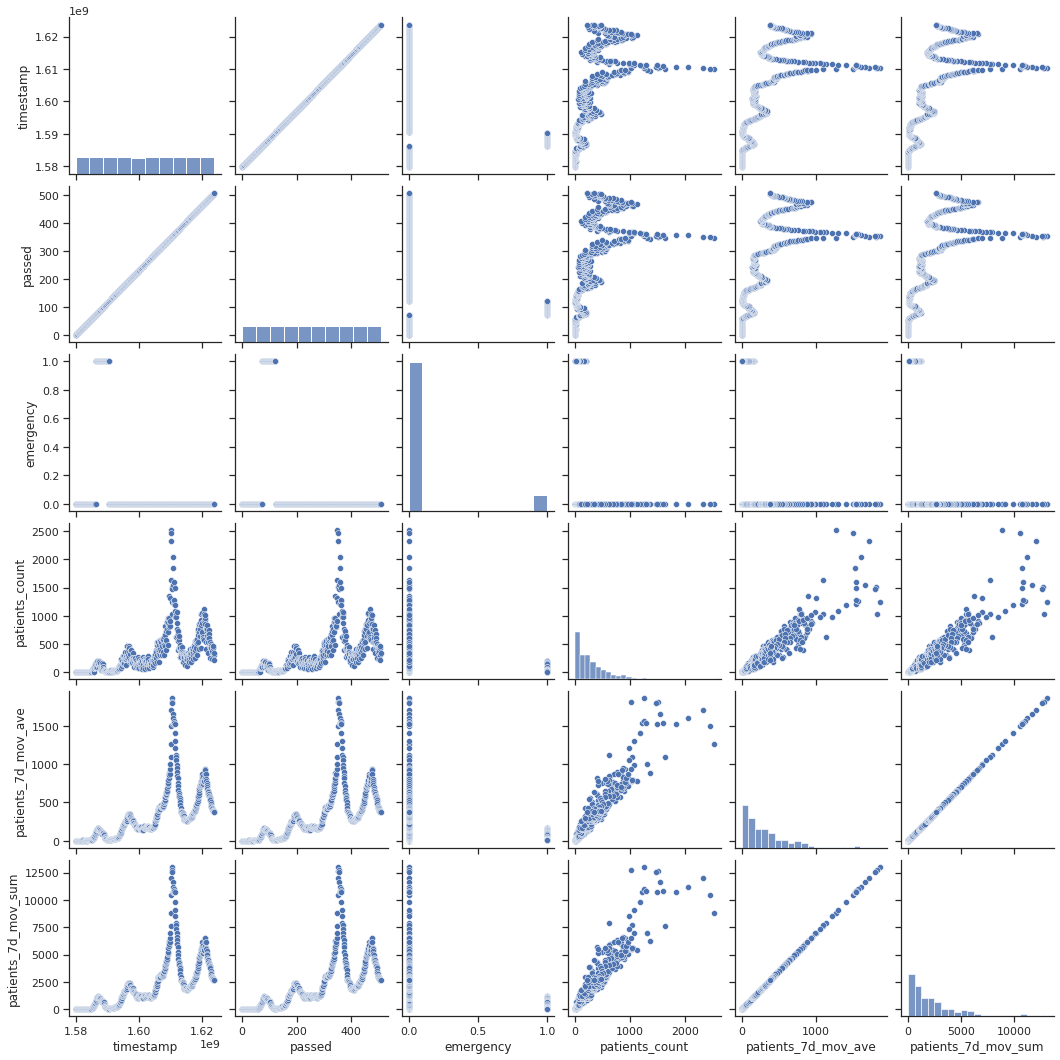

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
